In [1]:
# The genetic algorithm, tournament selection and single point crossover functions 
# and plotting the fitness were taken from EVO Lab 2. Author - Ing. Martin Hurta
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

In [ ]:
print("Generating adjacency matrix...")
n_vertices = 12 
graph = [[0] * n_vertices for _ in range(n_vertices)] 

for i in range(n_vertices):
    vertex1, vertex2 = random.sample(range(n_vertices),2)
    graph[vertex1][vertex2] = 1
    graph[vertex2][vertex1] = 1

print("done!")

In [5]:
def parse_file(filename):
    print(f"Creating a graph from file {filename}")
    with open(filename, 'r') as f:
        # Skip lines until we reach the line starting with 'p edge'
        line = f.readline().strip()
        while not line.startswith('p edge'):
            line = f.readline().strip()

        # Get the number of vertices from the 'p edge' line
        num_vertices = int(line.split()[2])

        # Create an empty adjacency matrix
        adjacency_matrix = [[0] * num_vertices for _ in range(num_vertices)]

        # Parse the edges and update the adjacency matrix
        for line in f:
            if line.startswith('e'):
                _, v1, v2 = line.split()
                v1, v2 = int(v1) - 1, int(v2) - 1  # Convert to 0-indexed
                adjacency_matrix[v1][v2] = 1
                adjacency_matrix[v2][v1] = 1  # Assuming undirected graph
        print("...done!")
        return adjacency_matrix, num_vertices

graph, num_vertices = parse_file('/content/queen5_5.col')

Creating a graph from file /content/queen5_5.col
...done!


In [6]:
# Variables to tweak with
max_colors = 5
num_runs = 5
                
num_generations = 400
population_size = 50
mutation_probability = 0.2
crossover_probability = 0.8

In [7]:
def tournament_selection(population, scores, k=2): 

    # Ziskani nahodneho poradi jedincu
    random_order = list(range(0, len(population)))
    np.random.shuffle(random_order)

    # Vyber prvniho jedince
    best_idx = random_order[0]
 
    # Turnaj se zbyvajicim poctem jedincu a ulozeni jedince s nejmensim score
    for i in range(1, k):

        if scores[random_order[i]] < scores[best_idx]:
            best_idx = random_order[i]

    return population[best_idx]

def fitness(solution): # Penalty for every vertex connecting 2 nodes with the same color
    fitness = 0
    for i in range(num_vertices):
        for j in range(i, num_vertices):
            if(solution[i] == solution[j] and graph[i][j] == 1):
                fitness += 1
    return fitness

def single_point_crossover(p1, p2, crossover_probability):
    
    # Inicializace potomku
    c1, c2 = p1.copy(), p2.copy()

    # Zjisteni, zda se provede krizeni
    if np.random.uniform() < crossover_probability:
        
        # Vyber nekoncoveho mista krizeni
        pt = np.random.randint(1, len(p1)-2)
        
        # Provedeni krizeni
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

def find_adjecent_colors(vertex, chromosone):
  adj_vertices = graph[vertex]
  adj_colors = [chromosone[i] for i in range(len(chromosone)) if adj_vertices[i] == 1]

  return adj_colors

def mutation_high_fit(chromosone, mutation_probability):
  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)
    if chromosone[vertex] in adj_colors:
      all_colors = [i for i in range(max_colors)]
      valid_colors = [all_colors[i] for i in range(max_colors) if all_colors[i] not in adj_colors]
      
      if(valid_colors): # If list is empty choose random color
        new_color = random.choice(valid_colors)
      else:
        new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

def mutation_low_fit(chromosone, mutation_probability):
  all_colors = [i for i in range(max_colors)]

  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)
    if chromosone[vertex] in adj_colors:
      new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

In [8]:
def genetic_algorithm(num_generations, population_size, crossover_probability, mutation_probability):
	
    # Radnom initial population inicialization
    population = [np.random.randint(0, max_colors-1, num_vertices).tolist() for _ in range(population_size)]

    # Inicializace nejlepsich reseni
    best_individual = 0
    best_eval = fitness(population[0])
    new_best = -1
    best_history = []

    # Evoluce
    gen = 0
    while(gen != num_generations and best_eval != 0):
    
        # Evaluace kandidatnich reseni
        scores = [fitness(indivitual) for indivitual in population]

        # Nalezeni nejlepsiho reseni
        for i in range(population_size):
            if scores[i] < best_eval:
                best_individual = population[i]
                best_eval = scores[i]
                new_best = i

        # Tisk informace o novem nejlepsim reseni
        if new_best != -1:
            print(">%d, new best f(%s) = %d, chromatic number = " % (gen,  population[new_best], scores[new_best]), max_colors)
            best_history.append([gen, scores[new_best]])
            new_best = -1

        # Vyber rodicu v poctu velikosti populace
        selected = [tournament_selection(population, scores) for _ in range(population_size)]

        # Jedinci pristi generace
        children = list()

        for i in range(0, population_size, 2):
            
            # Zvolni dvou predvybranych prvku
            p1, p2 = selected[i], selected[i+1]

            # Pripadne provedeni krizeni
            for c in single_point_crossover(p1, p2, crossover_probability):

                # Mutace jedincu
                if best_eval > 4:
                  mutation_high_fit(c, mutation_probability)
                else:
                  mutation_low_fit(c, mutation_probability)

                # Ulozeni jedincu do nove generace
                children.append(c)

        # Nahrazeni populace potomky
        population = children
        gen += 1
        if(gen == num_generations):
          print("Max number of generations reached ! Stopping evolution...")

    return [best_individual, best_eval, best_history]


>0, new best f([3, 2, 1, 1, 3, 3, 0, 2, 0, 2, 2, 1, 0, 0, 3, 0, 3, 0, 1, 1, 1, 3, 2, 3, 0]) = 25, chromatic number =  5
>1, new best f([3, 4, 4, 0, 3, 2, 1, 3, 0, 4, 2, 4, 1, 0, 2, 1, 0, 0, 3, 1, 4, 2, 3, 1, 0]) = 17, chromatic number =  5
>10, new best f([2, 3, 4, 0, 1, 0, 2, 1, 3, 3, 1, 2, 3, 4, 4, 4, 2, 3, 1, 0, 1, 0, 3, 2, 4]) = 16, chromatic number =  5
>11, new best f([1, 2, 0, 4, 0, 3, 4, 1, 3, 1, 3, 0, 1, 0, 2, 4, 1, 4, 3, 3, 2, 3, 0, 1, 0]) = 15, chromatic number =  5
>12, new best f([1, 3, 4, 2, 1, 4, 2, 1, 0, 3, 1, 2, 0, 3, 2, 3, 4, 0, 1, 4, 2, 4, 3, 1, 0]) = 14, chromatic number =  5
>18, new best f([2, 3, 0, 4, 1, 0, 1, 3, 4, 3, 4, 2, 2, 0, 2, 1, 0, 1, 3, 4, 3, 4, 1, 1, 0]) = 11, chromatic number =  5
>24, new best f([1, 2, 0, 4, 3, 0, 4, 3, 1, 2, 1, 0, 1, 2, 4, 2, 0, 4, 3, 1, 4, 1, 2, 3, 0]) = 9, chromatic number =  5
>56, new best f([0, 2, 3, 0, 1, 4, 1, 0, 2, 3, 2, 3, 4, 4, 0, 1, 0, 2, 3, 1, 3, 4, 1, 0, 2]) = 7, chromatic number =  5
>302, new best f([4, 1, 3, 0, 2, 0, 

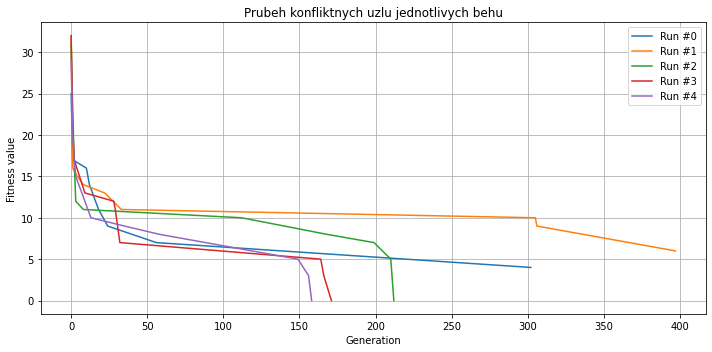

In [10]:

# Provedeni genetickeho algoritmu
results = [genetic_algorithm(num_generations, population_size, crossover_probability, mutation_probability) for _ in range(num_runs)]
num_successes = sum([1 for result in results if result[1] == 0])
success_rate = num_successes/num_runs

print(f'Done! Total success rate is {success_rate}')

# Plot prubehu nejlepsich reseni jednotlivych behu
figure, ax = plt.subplots(figsize=(10, 5))
for i in range(len(results)):
    ax.plot(*zip(*results[i][2]), label=f"Run #{i}")
ax.legend()
ax.grid()
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness value')
plt.title('Prubeh konfliktnych uzlu jednotlivych behu')
plt.tight_layout()
plt.show()